## makemore - simplest NN model with bigrams and trigrams


### Part 1: Prep and exploratory

In [7]:
names = open('data/names.txt', 'r').read().splitlines()
names[20:30]

['victoria',
 'madison',
 'luna',
 'grace',
 'chloe',
 'penelope',
 'layla',
 'riley',
 'zoey',
 'nora']

In [8]:
# create char to index mapping for set of chars in names

chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

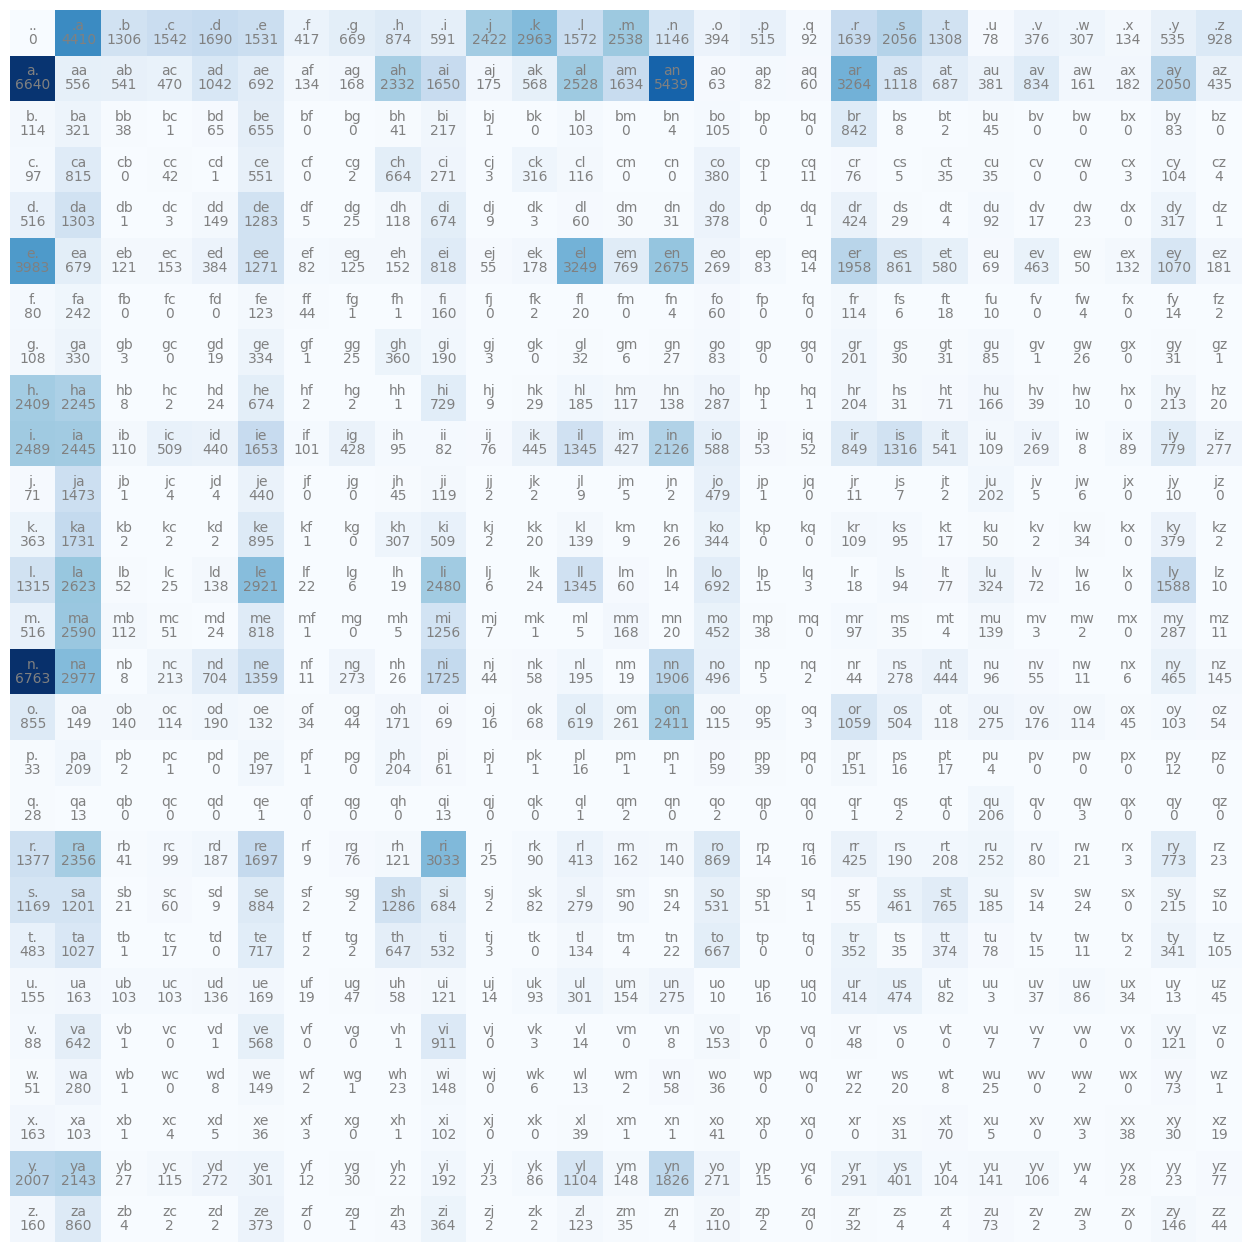

In [ ]:
import torch

# tensor for the char to index mapping (vocab size == 27)
N = torch.zeros((27, 27), dtype=torch.int32) 

# assign N the count of char to char transitions
for w in names:
  chs = ['.'] + list(w) + ['.'] # start/stop character
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1 # smoothing offset (no zero counts)


# visualize 
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [24]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for w in names[100:101]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(xs)
print(ys)

. p
p e
e y
y t
t o
o n
n .
tensor([ 0, 16,  5, 25, 20, 15, 14])
tensor([16,  5, 25, 20, 15, 14,  0])


In [ ]:
import torch.nn.functional as F

# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(745674124)
W = torch.randn((27, 27), generator=g)

# one-hot encode word vectors for input
xenc = F.one_hot(xs, num_classes=27).float()

 # predict log-counts, logits 
logits = xenc @ W

 # counts, equivalent to N tensor from above
counts = logits.exp()

 # softmax: probabilities for next character
probs = counts / counts.sum(1, keepdims=True)

In [26]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .p (indexes 0,16)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0034, 0.0317, 0.0142, 0.0333, 0.0462, 0.0222, 0.0144, 0.0190, 0.0415,
        0.0323, 0.0277, 0.0244, 0.1952, 0.0044, 0.0606, 0.0333, 0.0065, 0.0273,
        0.0499, 0.0174, 0.0637, 0.0540, 0.0340, 0.0664, 0.0470, 0.0120, 0.0180])
label (actual next character): 16
probability assigned by the net to the the correct character: 0.006513616535812616
log likelihood: -5.033860206604004
negative log likelihood: 5.033860206604004
--------
bigram example 2: pe (indexes 16,5)
input to the neural net: 16
output probabilities from the neural net: tensor([0.0207, 0.0346, 0.0216, 0.0211, 0.0132, 0.0031, 0.0203, 0.0344, 0.0620,
        0.0232, 0.0375, 0.0247, 0.0476, 0.0443, 0.1438, 0.0610, 0.1156, 0.0063,
        0.0083, 0.0400, 0.0077, 0.0011, 0.0060, 0.1171, 0.0235, 0.0082, 0.0533])
label (actual next character): 5
probability assigned by the net to the the correct character:

### Part 2: Bigram neural net (single linear layer)

In [27]:
import torch
import torch.nn.functional as F

names = open('data/names.txt', 'r').read().splitlines()

# create char to index mapping for set of chars in names
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

# create the dataset
xs, ys = [], []
for w in names:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

print('training set size (bigrams): ', xs.nelement())

# randomly initialize 27 neuron hidden layer, fully connected to 27 inputs for the character vocabulary 
g = torch.Generator().manual_seed(745674124)
W = torch.randn((27, 27), generator=g, requires_grad=True)

training set size (bigrams):  228148


In [ ]:
# training: gradient descent
passes = 100
learning_rate = 50
lambda_ = 0.01

for k in range(passes):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float()
  logits = xenc @ W 
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)
  loss = -probs[torch.arange(xs.nelement()), ys].log().mean() + lambda_*(W**2).mean() # adding L2 regularization loss (weight decay; mean instead of sum)
  print(loss.item())

  # note on using mean instead of sum for regularization:
  # λ_mean ​== d*λ_sum as we divide by the number of parameters to regularize to get the mean
  # effectively weaker regularization with mean unless rescaled by the number of parameters
  # mean keeps the regularization penalty roughly invariant with d
  
  # backward pass
  W.grad = None # set to zero the gradient (more efficient than 0 with torch)
  loss.backward()
  
  # update
  W.data += -learning_rate * W.grad

3.6845030784606934
3.337087392807007
3.1336517333984375
3.004291296005249
2.9144346714019775
2.84801983833313
2.798081159591675
2.7597901821136475
2.729651689529419
2.7052745819091797
2.6850850582122803
2.668041706085205
2.6534311771392822
2.6407432556152344
2.6296019554138184
2.6197237968444824
2.6108920574188232
2.6029398441314697
2.5957372188568115
2.5891804695129395
2.583186626434326
2.577688455581665
2.572628974914551
2.5679612159729004
2.5636439323425293
2.559643030166626
2.555927276611328
2.5524704456329346
2.549248456954956
2.5462400913238525
2.543426990509033
2.540792942047119
2.538322687149048
2.536003828048706
2.5338234901428223
2.531771183013916
2.5298378467559814
2.5280134677886963
2.5262911319732666
2.5246634483337402
2.523123025894165
2.52166485786438
2.520282506942749
2.5189714431762695
2.517725944519043
2.5165419578552246
2.515416145324707
2.514343500137329
2.5133211612701416
2.512346029281616
2.511414051055908
2.510524034500122
2.5096726417541504
2.508857250213623
2.5

In [ ]:
# sample from the simple NN model
g = torch.Generator().manual_seed(745654124)

for i in range(12):
  
  out = []
  ix = 0
  while True:

    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W 
    counts = logits.exp()
    p = counts / counts.sum(1, keepdims=True)
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0: # the preset special character
      break
  print(''.join(out))

amyaren.
go.
ss.
maillpharapetiniem.
kmicnareserlike.
reedeswpaa.
tarydan.
te.
nennzoilair.
maria.
cortar.
ma.


#### Exercises
- [ ] E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?
- [ ] E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?
- [ ] E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?
- [ ] E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?
- [ ] E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

### Exercise: Trigram model

Key changes:

- Pad with two start tokens: chs = ['.', '.'] + list(w) + ['.']
- 2-char contexts; a single index idx = ix1*V + ix2 where V=27
- One-hot size becomes V*V
- Weight matrix becomes (V*V, V)
- Sampling keeps a rolling 2-char context

In [33]:
# if not already run above
import torch
import torch.nn.functional as F

names = open('data/names.txt', 'r').read().splitlines()

# create char to index mapping for set of chars in names
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [36]:
# vocabulary size (permutations of chars + special 'n' char)
V = len(stoi)          # 27 for this dataset
V2 = V * V             # 729 for trigrams

# create the trigram dataset
xs, ys = [], []
for w in names:
  chs = ['.', '.'] + list(w) + ['.'] # pad with two starting characters for 2-char context
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    iy = stoi[ch3]

    # create a new integer representation, idx, for each of the 2-char contexts 
    idx = ix1 * V + ix2
    xs.append(idx)
    ys.append(iy)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

print('training set size (trigrams): ', xs.nelement())

# randomly initialize 27 neuron hidden layer, fully connected to 27 inputs for the character vocabulary 
g = torch.Generator().manual_seed(745674124)
W = torch.randn((V2, V), generator=g, requires_grad=True) # 729 x 27


# training: gradient descent
passes = 125
learning_rate = 50
lambda_ = 0.01

for k in range(passes):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=V2).float() # num_classes is now all 2-char contexts (27**2)
  logits = xenc @ W 
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)
  loss = -probs[torch.arange(xs.nelement()), ys].log().mean() + lambda_*(W**2).mean() # L2 regularization
  print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient (more efficient than 0 with torch)
  loss.backward()
  
  # update
  W.data += -learning_rate * W.grad


training set size (trigrams):  228148
3.7527973651885986
3.648306131362915
3.5732932090759277
3.510197639465332
3.4539217948913574
3.402848720550537
3.3561534881591797
3.3132102489471436
3.2735610008239746
3.2369112968444824
3.203054904937744
3.1717982292175293
3.1429247856140137
3.1162006855010986
3.09139084815979
3.0682740211486816
3.046656608581543
3.026371955871582
3.007281541824341
2.989267587661743
2.972231388092041
2.956087350845337
2.9407615661621094
2.9261865615844727
2.9123055934906006
2.8990638256073
2.8864150047302246
2.874315023422241
2.862724781036377
2.851609706878662
2.8409364223480225
2.8306760787963867
2.8208019733428955
2.8112893104553223
2.802116632461548
2.793262243270874
2.7847084999084473
2.776437282562256
2.768433094024658
2.76068115234375
2.7531681060791016
2.7458808422088623
2.7388079166412354
2.7319390773773193
2.725263833999634
2.7187719345092773
2.712456464767456
2.706308126449585
2.700319766998291
2.694484233856201
2.6887948513031006
2.6832456588745117
2.6

In [37]:
# sample from the trigram NN model
g = torch.Generator().manual_seed(745654124)

for _ in range(12):
  out = []
  ix1 = 0   # '.'
  ix2 = 0   # '.'
  while True:
    ctx = ix1 * V + ix2                        # pack the 2-char context
    xenc = F.one_hot(torch.tensor([ctx]), num_classes=V2).float()
    logits = xenc @ W
    counts = logits.exp()
    p = counts / counts.sum(1, keepdims=True)

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:                                # sampled end token '.'
      break
    ix1, ix2 = ix2, ix                         # slide the 2-char window
  print(''.join(out))

amyyjqk.
guissa.
kilpphuanpylin.
em.
kmvcnqqqsvcwxpscrceden.
paaqoqr.
dann.
ben.
nizxivair.
maria.
cortleymaryley.
vijadain.
